In [1]:
import numpy as np
import os
import pandas as pd
from sklearn import cluster
import shutil
np.random.seed(0)
import pathlib2

In [2]:
import sys
sys.path.insert(0,'../../pyImagePlot/')

from PyImagePlot import montage_manager

In [3]:
def quantile_function(df, quantile_point, col = 'dist'):
    #Get the quantile value
    quantile_value = df.quantile(quantile_point)[col]
    #Select the data in the group that falls at or below the quantile value and return it
    return df[df[col] <= quantile_value]

In [4]:
from osgeo import osr, gdal,gdal_array

ds = gdal.Open("../data/planet_imagery/1154314_2014-07-23_RE2_3A_Analytic_clip.tif", gdal.GA_ReadOnly)
# DataType is a property of the individual raster bands
image_datatype = ds.GetRasterBand(1).DataType

# Allocate our array, but in a more efficient way
image_correct = np.zeros((ds.RasterYSize, ds.RasterXSize, ds.RasterCount),
                 dtype=gdal_array.GDALTypeCodeToNumericTypeCode(image_datatype))

# Loop over all bands in dataset
for b in range(ds.RasterCount):
    # Remember, GDAL index is on 1, but Python is on 0 -- so we add 1 for our GDAL calls
    band = ds.GetRasterBand(b + 1)
    
    # Read in the band's data into the third dimension of our array
    image_correct[:, :, b] = band.ReadAsArray()


In [5]:
image_correct.shape
image_flatten = image_correct.reshape(2904*1920,5)
#image_flatten_ndvi = np.hstack((image_flatten,np.column_stack((image_flatten[:,4]-image_flatten[:,3])/(image_flatten[:,4]+image_flatten[:,3])).T))

In [6]:
#ds_cluster = gdal.Open("/data/gdrive/Data/Clusters/ClusterRaster24_update.tif", gdal.GA_ReadOnly)
#ds_cluster = gdal.Open("../data/landsat/ClusterRaster24_update.tif", gdal.GA_ReadOnly)
df_cond = pd.DataFrame(image_flatten.tolist())
#df_cond['cluster'] = np.column_stack(ds_cluster.ReadAsArray().flatten())[0]

In [7]:
df_cond.shape

(5575680, 5)

In [8]:
#ds_cluster.ReadAsArray()

In [9]:
from sklearn.preprocessing import StandardScaler
x_scaled = StandardScaler().fit_transform(df_cond.as_matrix().astype(np.float64))
X_sklearn = x_scaled
#from sklearn.decomposition import PCA
#sklearn_pca = PCA(n_components=6)
#X_sklearn = sklearn_pca.fit_transform(x_scaled)

In [10]:
#k_means = cluster.KMeans(n_clusters=24,random_state=3254)
#k_means = cluster.KMeans(n_clusters=10,random_state=3254)
k_means = cluster.MiniBatchKMeans(n_clusters=50,random_state=3254)
k_means.fit(X_sklearn) 
y_kmeans = k_means.predict(X_sklearn)
df_cond['cluster'] = y_kmeans

In [11]:
# Verify raster matches calculated cluster
np.array_equal(y_kmeans, df_cond['cluster'].tolist())

True

In [12]:
base_path = "data/tiles/Escondido2014_utm_forcep5_clip/jpg/"
file_name = "Escondido2014_utm_forcep5_clip"
#base_path = "data/tiles/1154314_2014-07-23_RE2_3A_Analytic_clip/jpg/"
#file_name = "1154314_2014-07-23_RE2_3A_Analytic_clip"

df_cond['image_paths'] = base_path + file_name + df_cond.index.astype(str) + ".jpg"

In [13]:
df_cond['dist'] = 0.0
for index, row in df_cond.iterrows():
    df_cond['dist'].iat[index] = np.linalg.norm(X_sklearn[index]-k_means.cluster_centers_[row['cluster']])


In [14]:
df_cond.head()

,0,1,2,3,4,cluster,image_paths,dist
0,10156,10360,10188,9253,8359,7,data/tiles/Escondido2014_utm_forcep5_clip/jpg/...,0.476810
1,10541,10514,10083,9175,9308,26,data/tiles/Escondido2014_utm_forcep5_clip/jpg/...,0.434461
2,10619,9845,9071,8712,9363,7,data/tiles/Escondido2014_utm_forcep5_clip/jpg/...,0.480834
3,9202,8978,8564,7857,8489,42,data/tiles/Escondido2014_utm_forcep5_clip/jpg/...,0.223407
4,9699,9874,8689,7702,7861,33,data/tiles/Escondido2014_utm_forcep5_clip/jpg/...,0.406925


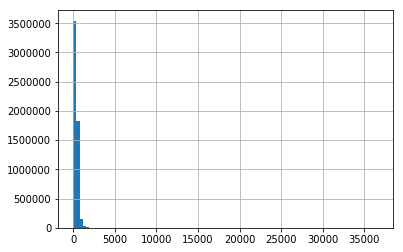

In [15]:
import matplotlib.pyplot as plt
(df_cond['dist'] * 1000).hist(bins=100)
plt.show()

In [16]:
df_cond['dist'] = (df_cond['dist'] * 1000).apply(np.floor)
df_cond['dist'] = df_cond['dist'].astype(int)

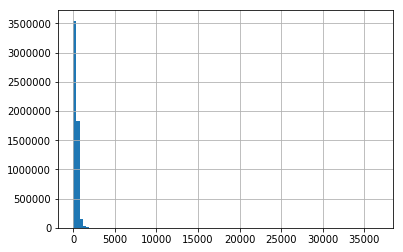

In [17]:
df_cond['dist'].hist(bins=100)
plt.show()

In [18]:
#change
write_path = "../data/digitalglobe/results/cluster50landsat_pl/"
combined_write_path = "escondido-train-test.csv"
img_hist_write_path = "escondido-img-hist-pltop1000nearest.png"
montage_dirs_path = "../data/digitalglobe/results/cluster10landsat_pl/escondido/clusters-montages/"
images_clusterd_dir_root = "../data/digitalglobe/results/cluster10landsat_pl/escondido/clustered-images/cluster_"

if not os.path.exists(write_path):
    os.makedirs(write_path)

In [19]:
#df_cond[['image_paths','cluster','dist']].to_csv(combined_write_path, index = False)
#df_cond[['image_paths','cluster','dist']].groupby('cluster', group_keys=False).apply(quantile_function, 0.5).to_csv(write_path + combined_write_path, index = False)
df_cond[['image_paths','cluster','dist']].iloc[list(df_cond.groupby('cluster', group_keys=False)['dist'].nsmallest(1000).index.levels[1])].to_csv(write_path + combined_write_path, index = False)



In [20]:
df = pd.read_csv(write_path + combined_write_path)
df.shape

(50000, 3)

In [21]:
list_picture_index = list(df_cond[['image_paths','cluster','dist']].iloc[list(df_cond.groupby('cluster', group_keys=False)['dist'].nsmallest(1000).index.levels[1])].index)

In [22]:
from PIL import Image,ImageEnhance

output_dir = "data/tiles"
raw_file_location = "../data/digitalglobe/Escondido2014_utm_forcep5_clip.tif"
raw_file_name = "Escondido2014_utm_forcep5_clip"
color_band_order = [0,1,2]

ds = gdal.Open(raw_file_location, gdal.GA_ReadOnly)
# DataType is a property of the individual raster bands
image_datatype = ds.GetRasterBand(1).DataType

# Allocate our array, but in a more efficient way
image_correct = np.zeros((ds.RasterYSize, ds.RasterXSize, ds.RasterCount),
                 dtype=gdal_array.GDALTypeCodeToNumericTypeCode(image_datatype))

# Loop over all bands in dataset
#for b in range(ds.RasterCount):
for b in range(ds.RasterCount):
    # Remember, GDAL index is on 1, but Python is on 0 -- so we add 1 for our GDAL calls
    band = ds.GetRasterBand(b + 1)
    
    # Read in the band's data into the third dimension of our array
    image_correct[:, :, b] = band.ReadAsArray()

# Order the bands into red, green, blue
image_correct = image_correct[:, :, color_band_order]

cols = ds.RasterXSize
rows = ds.RasterYSize

transform = ds.GetGeoTransform()
minx = transform[0]
maxx = transform[0] + cols * transform[1] + rows * transform[2]

miny = transform[3] + cols * transform[4] + rows * transform[5]
maxy = transform[3]

width = maxx - minx
height = maxy - miny

xOrigin = transform[0]
yOrigin = transform[3]
pixelWidth = transform[1]
pixelHeight = -transform[5]

print (xOrigin, yOrigin)

squaresize = 10

m = int(rows/squaresize)
n = int(cols/squaresize)

print (rows,cols)
print (m,n)

list_patches = []
pathlib2.Path(os.path.join(output_dir, raw_file_name, 'jpg')).mkdir(parents=True, exist_ok=True) 

for j in range(m, 0, -1):
    for i in range(0, n):
        list_patches.append(image_correct[(m-j)*squaresize:(m-j)*squaresize+squaresize, i*squaresize:i*squaresize+squaresize, :])
            
for x in list_picture_index:
    blue = Image.fromarray(list_patches[x][:,:,2], "L")
    green = Image.fromarray(list_patches[x][:,:,1], "L")
    red = Image.fromarray(list_patches[x][:,:,0], "L")
    out = Image.merge("RGB", (red, green, blue))
    out = out.resize((60,60))
    out.save(os.path.join(output_dir, raw_file_name, 'jpg', raw_file_name +str(x)+".jpg"))

(480894.4629851412, 3667501.770068448)
(29045, 19200)
(2904, 1920)


In [23]:

Image.fromarray(list_patches[0][:,:,2], "L")

In [23]:
M = montage_manager.Montages()
f = os.path.abspath(write_path + combined_write_path)
img_hist = M.create_image_hist(src_path=f)
img_hist.save(write_path + img_hist_write_path)

In [98]:
# M = montage_manager.Montages()
# f = os.path.abspath(combined_write_path)
# img_hist = M.create_image_hist(src_path=f)
# img_hist.save(img_hist_write_path)
# montages = M.binned_montage(df, img_paths_col="image_path", bins_col="cluster", vals_col="dist")


number of images: 6580
number of images: 13797
number of images: 7487
number of images: 4914
number of images: 1762
number of images: 5492
number of images: 472
number of images: 2653
number of images: 10709
number of images: 8021
number of images: 139
number of images: 2230
number of images: 9547
number of images: 6409
number of images: 18396
number of images: 137
number of images: 6789
number of images: 13203
number of images: 476
number of images: 2624
number of images: 9865
number of images: 18461
number of images: 3889
number of images: 827


In [99]:
if not os.path.exists(montage_dirs_path):
    os.makedirs(montage_dirs_path)
        
for montage in montages:
    montage[0].save(montage_dirs_path + "cluster_" + montage[1]+".png")

In [100]:
target_dir = images_clusterd_dir_root
for i in range(df.shape[0]):
    image_path = df.image_paths[i]
    cluster = df.cluster.iloc[i]
    write_path = target_dir + str(cluster) + '/'
    
    if not os.path.exists(write_path):
        os.makedirs(write_path)

    shutil.copy2(image_path, write_path)